In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.distributions import Normal
from scipy.linalg import block_diag
from numpy.linalg import inv
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import pdist, squareform
import numpy.matlib as nm
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

In [2]:
def get_lstm_params(num_inputs, num_hiddens, num_outputs, num_units):
    
    def normal(shape):
        return Variable(nn.Parameter(torch.randn(size = shape))) * 0.01
    def zero(shape):
        return Variable(nn.Parameter(torch.zeros(shape)))
    def three(num_inputs, num_hiddens, num_outputs):
        return (normal((num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)), zero(num_hiddens))
    
    W_xi, W_hi, b_i = three(num_inputs, num_hiddens, num_outputs) # 输入门参数
    W_xf, W_hf, b_f = three(num_inputs, num_hiddens, num_outputs) # 遗忘门参数
    W_xo, W_ho, b_o = three(num_inputs, num_hiddens, num_outputs) # 输出门参数
    W_xc, W_hc, b_c = three(num_inputs, num_hiddens, num_outputs) # 候选记忆门参数
    
    # 输出层参数
    W_hq = normal((num_units, num_hiddens, num_outputs))
    
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq]
    for param in params:
        param.requires_grad_(True)
    
    return params 

In [3]:
def init_lstm_state(batch_size, num_hiddens):
    return (torch.ones(batch_size, num_hiddens)*(-20.0), 
            torch.ones(batch_size, num_hiddens)*(-20.0))

In [4]:
def lstm(inputs, state, unit_index, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c] = params[:12]
    W_hq = params[12][unit_index]
    (H, C) = state
    
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)

        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda 
        H = O * torch.relu(C)
        Y = H @ W_hq
        outputs.append(Y)

    return torch.cat(outputs, dim = 0)

In [5]:
class RNNModelScratch():
    def __init__(self, num_inputs, num_hiddens, num_outputs, 
                 num_units, get_params, init_state, forward_fn):   
        self.num_inputs, self.num_hiddens = num_inputs, num_hiddens
        self.num_outputs, self.num_units = num_outputs, num_units
        self.params = get_params(num_inputs, num_hiddens, num_outputs, num_units)
        self.init_state, self.forward_fn = init_state, forward_fn
        
    def __call__(self, X, state, unit_index):
        return self.forward_fn(X, state, unit_index, self.params)
    
    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.num_hiddens)

In [6]:
class SVGD():

    def __init__(self):
        pass
    
    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2  # 转化为距离矩阵
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy)
    
 
    def update(self, x0, historical_grad, lnprob, n_iter, stepsize, bandwidth = -1, alpha = 0.9, debug = False):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')
        
        theta = np.copy(x0) 
        
        # adagrad with momentum
        fudge_factor = 1e-6
        # historical_grad = 0
        # for iter in range(n_iter):
        #    if debug and (iter+1) % 1000 == 0:
        #        print('iter ' + str(iter+1))
            
        lnpgrad = lnprob(theta)
        # calculating the kernel matrix
        kxy, dxkxy = self.svgd_kernel(theta, h = -1)  
        grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]  

        # adagrad 
        if n_iter == 0:
            historical_grad = historical_grad + grad_theta ** 2
        historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
        
        adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
        # theta = theta + stepsize * adj_grad 
            
        return adj_grad, historical_grad

In [7]:
class MVN:
    def __init__(self, mu, A):
        self.mu = mu
        self.A = A # 协方差的逆矩阵
    
    def dlnprob(self, theta):
        return -1*np.matmul(theta-nm.repmat(self.mu, theta.shape[0], 1), self.A)

In [8]:
def train(net, lr, num_epochs, inputs, targets, batch_size, model, step_size, valid_obv):
    # train(net, lr, num_epochs, X, train_data, batch_size, model, step_size, valid_obv)
    loss = nn.MSELoss()
    updater = optim.Adam(net.params, lr)
    num_unit = len(inputs)
    
    historical_grad = 0
    loss_lt = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        L = torch.zeros(num_unit)      
        for i in range(num_unit):
            tmp_obv = valid_obv[i]
            state = net.begin_state(batch_size)
            y_preb = net(inputs[i], state, i)
            L[i] = loss(y_preb[tmp_obv], targets[i][tmp_obv])
        
        tmp_gamma = net.params[12].detach().permute(0,2,1).numpy().reshape(num_unit, -1)
        grad, historical_grad = SVGD().update(tmp_gamma, historical_grad, model.dlnprob, epoch, step_size)
        
        loss_lt[epoch] = L.mean().item()
        updater.zero_grad()
        L.mean().backward()
        updater.step()
        
        net.params[12].data += step_size * torch.tensor(grad.reshape(num_unit,3,num_sensors), dtype=torch.float)
        # net.params[12] = torch.tensor(net.params[12].detach().numpy(), dtype=torch.float, requires_grad=True)
        
        if epoch % 10 == 0:
            print('epoch:{}/{}'.format(epoch+1, num_epochs))
            print('Loss:', L.mean().item())

    print('finished training!')

    return loss_lt

In [9]:
# A = np.diag(np.ones(18))
# mu = np.zeros(18)

A = np.load('cov1.npy')
mu = np.load('mu1.npy').reshape(-1)

model1 = MVN(mu, A)

In [10]:
#  读入训练数据
df_train = pd.read_csv('train_data.csv')
num_units = df_train['Unit'].max()
num_train = 20
num_sensors = 6

np.random.seed(111)
selected_unit = np.random.choice(num_units, num_train, replace=False)

t = [torch.tensor([i/500.0]) for i in range(500)]
T = []
train_data = []
lengths = []

for i in selected_unit:
    sensor_data = torch.tensor(df_train[df_train['Unit'] == i+1].iloc[:,2:].values, dtype = torch.float)  
    T.append(t[:sensor_data.shape[0]])
    train_data.append(sensor_data)
    lengths.append(len(sensor_data)) 

In [12]:
num_inputs = 1
num_hiddens = 3
num_outputs = 6
net = RNNModelScratch(num_inputs, num_hiddens, num_outputs, num_train, get_lstm_params, init_lstm_state, lstm)
net.params = torch.load('LSTM-SVGD(20)-1.pth')

In [13]:
def get_H(inputs, params, num_hiddens):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c] = params[:12]
    (H, C) = init_lstm_state(1, num_hiddens)
    H_lt = torch.zeros((len(inputs), num_hiddens))
    for i in range(len(inputs)):
        X = inputs[i]
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)

        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda 
        H = O * torch.relu(C)
        
        H_lt[i] = H
    
    return H_lt

In [14]:
def predict_sensors(net, inputs, targets, unit_index): 
    fig = plt.figure(figsize=(15,5))
    state = net.begin_state(1)
    y_preb = net(inputs, state, unit_index)
    
    for i in range(6):
        plt.subplot(2, 3, 1+i)
        plt.plot(targets[8:,i], 'o', alpha=0.5)
        plt.plot(y_preb[8:,i].detach().numpy(), color='#FF8D57', linewidth = 3)
        
    plt.subplots_adjust(wspace = 0.25, hspace = 0.35)
    plt.show()

In [15]:
def predict_sensors2(targets, unit_index, valid_len): 
    fig = plt.figure(figsize=(12,4))
    tmp_Psi = Psi[:valid_len]
    y_pred = tmp_Psi @ gamma[unit_index].T
    
    for i in range(6):
        plt.subplot(2, 3, 1+i)
        t1 = np.arange(len(targets))
        t2 = np.arange(len(tmp_Psi))
        plt.plot(t1[8:], targets[8:,i], '.', markersize=3)
        plt.plot(t2[8:], y_pred[8:,i], color='#FF8D57', linewidth = 3)
        
    plt.subplots_adjust(wspace = 0.25, hspace = 0.35)
    plt.show()

In [16]:
# num_train = 20
Psi = get_H(t, net.params, num_hiddens).detach().numpy()

tmp_gamma = net.params[12].detach().numpy()
gamma = np.zeros((num_train, num_sensors, num_hiddens))
for i in range(num_train):
    gamma[i] = tmp_gamma[i].T
    
Psi.shape, gamma.shape

((500, 3), (20, 6, 3))

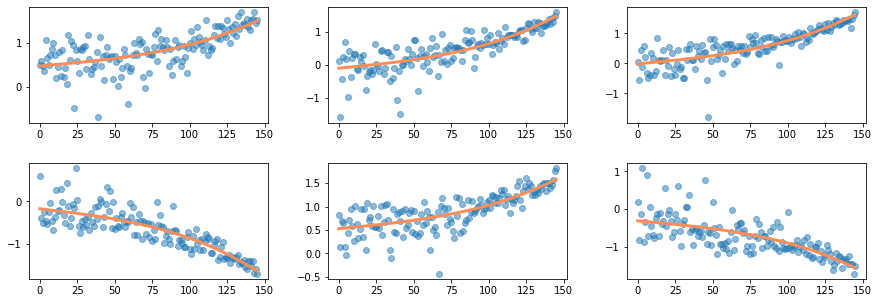

In [17]:
unit_index = 6
predict_sensors(net, T[unit_index], train_data[unit_index], unit_index)

In [18]:
lam, Th = 0.1, 1.2 # 大于Th的时间点被认为是异常点
valid_obv = []
    
for i in range(num_train):
    unit_i = selected_unit[i] 
    L = df_train[df_train['Unit'] == unit_i+1].iloc[:,2:].values
    tmp_n, q = lengths[i], 2
    tmp_Psi = Psi[:tmp_n]

    # 初始化
    H = tmp_Psi @ inv(tmp_Psi.T @ tmp_Psi + 1e-6*np.diag(np.ones(tmp_Psi.shape[1]))) @ tmp_Psi.T
    X = np.eye(H.shape[0]) - H


    Y = X @ L
    gamma = inv(X.T @ X + lam*np.eye(X.shape[0])) @ X.T @ Y
    R = np.zeros(gamma.shape[0])

    for j in range(gamma.shape[0]):
        tmp_gamma = gamma[j].reshape(1,-1)
        R[j] = tmp_gamma @ tmp_gamma.T

    # update
    valid_obv.append(np.where(R<Th))

In [23]:
net = RNNModelScratch(num_inputs, num_hiddens, num_outputs, num_train, get_lstm_params, init_lstm_state, lstm)
net.params = torch.load('LSTM-SVGD-Pre(20)-1-2.pth')

In [27]:
num_epochs, lr = 1000, 0.001
batch_size, step_size = 1, 1e-6
loss_lt = train(net, lr, num_epochs, T, train_data, batch_size, model1, step_size, valid_obv)

epoch:1/1000
Loss: 0.0968545526266098
epoch:11/1000
Loss: 0.09530701488256454
epoch:21/1000
Loss: 0.09397627413272858
epoch:31/1000
Loss: 0.09275902807712555
epoch:41/1000
Loss: 0.09154531359672546
epoch:51/1000
Loss: 0.09038585424423218
epoch:61/1000
Loss: 0.08931343257427216
epoch:71/1000
Loss: 0.08836351335048676
epoch:81/1000
Loss: 0.08756707608699799
epoch:91/1000
Loss: 0.08694078028202057
epoch:101/1000
Loss: 0.08648084849119186
epoch:111/1000
Loss: 0.08616256713867188
epoch:121/1000
Loss: 0.08594801276922226
epoch:131/1000
Loss: 0.08579783141613007
epoch:141/1000
Loss: 0.08568078279495239
epoch:151/1000
Loss: 0.08557653427124023
epoch:161/1000
Loss: 0.08547355234622955
epoch:171/1000
Loss: 0.08536529541015625
epoch:181/1000
Loss: 0.08524715155363083
epoch:191/1000
Loss: 0.08511468023061752
epoch:201/1000
Loss: 0.08497007936239243
epoch:211/1000
Loss: 0.08478926867246628
epoch:221/1000
Loss: 0.08457882702350616
epoch:231/1000
Loss: 0.08433133363723755
epoch:241/1000
Loss: 0.08403

In [72]:
num_epochs, lr = 300, 0.001
batch_size, step_size = 1, 1e-6
loss_lt = train(net, lr, num_epochs, T, train_data, batch_size, model1, step_size, valid_obv)

epoch:1/300
Loss: 0.05890559032559395
epoch:11/300
Loss: 0.05893845111131668
epoch:21/300
Loss: 0.05890127271413803
epoch:31/300
Loss: 0.0589003749191761
epoch:41/300
Loss: 0.05889955908060074
epoch:51/300
Loss: 0.05889401584863663
epoch:61/300
Loss: 0.05889207124710083
epoch:71/300
Loss: 0.05888918787240982
epoch:81/300
Loss: 0.05888650566339493
epoch:91/300
Loss: 0.05888376757502556
epoch:101/300
Loss: 0.05888093635439873
epoch:111/300
Loss: 0.058878012001514435
epoch:121/300
Loss: 0.058875005692243576
epoch:131/300
Loss: 0.058871932327747345
epoch:141/300
Loss: 0.058868806809186935
epoch:151/300
Loss: 0.05886562913656235
epoch:161/300
Loss: 0.058862410485744476
epoch:171/300
Loss: 0.05885915085673332
epoch:181/300
Loss: 0.05885588377714157
epoch:191/300
Loss: 0.058852583169937134
epoch:201/300
Loss: 0.0588492751121521
epoch:211/300
Loss: 0.058845944702625275
epoch:221/300
Loss: 0.05884261801838875
epoch:231/300
Loss: 0.058839283883571625
epoch:241/300
Loss: 0.0588359609246254
epoch:

In [71]:
torch.save(net.params, 'LSTM-SVGD-Pre(20)-3-3.pth')

In [24]:
t = [torch.tensor([i/500.0]) for i in range(500)]

Psi = get_H(t, net.params, num_hiddens).detach().numpy()

tmp_gamma = net.params[12].detach().numpy()
gamma = np.zeros((num_train, num_sensors, num_hiddens))
for i in range(num_train):
    gamma[i] = tmp_gamma[i].T
    
Psi.shape, gamma.shape

((500, 3), (20, 6, 3))

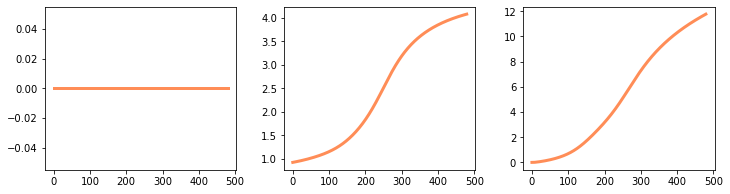

In [25]:
fig = plt.figure(figsize=(12,3))

for i in range(3):
    plt.subplot(1, 3, 1+i)
    plt.plot(Psi[20:,i], color='#FF8D57', linewidth = 3)

plt.subplots_adjust(wspace = 0.25, hspace = 0.35)
plt.show()

In [26]:
# 计算传感器噪声方差
sigma2 = np.zeros(num_sensors)

for i in range(num_sensors):
    tmp_sigma2 = 0
    tmp_m = 0
    for j in range(num_train):
        gamma_j = gamma[j,i]
        sensor_data = train_data[j][:,i].detach().numpy()
        tmp_n = lengths[j]
        
        tmp_Psi = Psi[:tmp_n]
        sensor_path = tmp_Psi @ gamma_j
        
        tmp_sigma2 += np.power(sensor_path - sensor_data, 2).sum()
        tmp_m += (tmp_n - 6)
        
    sigma2[i] = tmp_sigma2/tmp_m
sigma2

array([0.09503398, 0.06571945, 0.06993852, 0.06190422, 0.09494276,
       0.08376487])

In [27]:
# gamma的均值和协方差
cov_list = []
for i in range(num_sensors):
    data_i = gamma[:,i]
    cov_i = np.cov(data_i.T)
    cov_list.append(cov_i)
    
cov = block_diag(cov_list[0],cov_list[1],cov_list[2],cov_list[3],cov_list[4],cov_list[5])
# cov = np.cov(gamma.reshape(num_train,-1).T)
mu = gamma.reshape(num_train,-1).mean(axis=0).reshape(-1,1)

cov.shape, mu.shape

((18, 18), (18, 1))

In [28]:
# num_train = 100

mu_i = np.zeros((num_train, 3*num_sensors,1)) 
cov_i = np.zeros((num_train,3*num_sensors,3*num_sensors))

for i in range(num_train):
    tmp_n = lengths[i]
    obv_list = valid_obv[i]
    tmp_psi = Psi[:tmp_n][obv_list]
    
    Psi_i = block_diag(tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi)
    # 构建块对角矩阵
    omega_i = np.diag(np.repeat(sigma2.reshape(-1,1),len(obv_list[0]),axis=1).flatten())

    L_i = train_data[i][obv_list].detach().numpy().T.flatten().reshape(-1,1) # n_i*1
    
    # 计算后验分布
    tmp_cov = inv(Psi_i.T @ inv(omega_i) @ Psi_i + inv(cov))
    tmp_mu = tmp_cov @ (Psi_i.T @ inv(omega_i) @ L_i + inv(cov) @ mu)
    
    mu_i[i] = tmp_mu
    cov_i[i] = tmp_cov

In [29]:
# 设置特征值-logistic regression
N, delta, K = 80, 1, 25 # 超参数
inputs = np.zeros((K*num_train,2*N,num_sensors))

for i in range(num_train):
    M = lengths[i]
    gamma_samples = np.random.multivariate_normal(mu_i[i].flatten(), cov_i[i], size=K)  
    
    tt = torch.zeros(2*N, dtype=torch.long)
    for j in range(2*N):
        tt[j] = M + (j-N+1) * delta
        
    for k in range(K):
        inputs[i*K+k] = (Psi @ gamma_samples[k].reshape(num_sensors,-1).T)[tt]
        
# 设置标签值
labels = np.hstack((np.zeros(N), np.ones(N))).reshape(1,-1)
# print(label.shape) (1,160)
labels = np.repeat(labels, K*num_train, axis=0)

inputs.shape, labels.shape

((500, 160, 6), (500, 160))

In [30]:
from sklearn.linear_model import LogisticRegression
X_train = inputs.reshape(-1,num_sensors)
Y_train = labels.reshape(-1,1)
X_train.shape, Y_train.shape

model2 = LogisticRegression(penalty="l2", C=0.01, solver="sag", max_iter=1000) #创建模型
model2.fit(X_train, Y_train.ravel()) #训练

LogisticRegression(C=0.01, max_iter=1000, solver='sag')

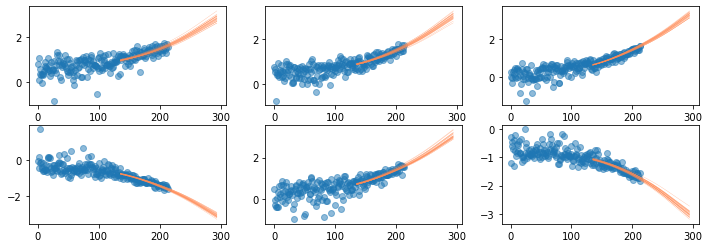

In [31]:
index = 10
sensor_data = train_data[index]

M = lengths[index]
t = torch.zeros(2*N, dtype=torch.long)
for j in range(2*N):
    t[j] = M + (j-N+1) * delta

fig = plt.figure(figsize=(12,4))
for i in range(6):
    plt.subplot(2, 3, 1+i)
    plt.plot(sensor_data[:,i], 'o', alpha=0.5)
    for k in range(K):
        sensor_path = inputs[index*K + k]
        plt.plot(t, sensor_path[:,i], color='#FF8D57', linewidth = 0.2)

In [32]:
df_test = pd.read_csv('test_data.csv')
num_test = df_test['Unit'].max()      # 测试数据数量

test_data = []
test_lengths = []
for i in range(num_test):
    Y = np.array(df_test[df_test['Unit']==i+1].iloc[:,2:]) 
    test_data.append(Y)
    test_lengths.append(len(Y))

lam, Th = 0.1, 0.8
    
updated_data = []
for i in range(num_test):
    L = test_data[i]
    tmp_n, q = test_lengths[i], 2
    tmp_Psi = Psi[:tmp_n]
    
    # B = (inv(tmp_Psi.T @ tmp_Psi) @ tmp_Psi.T @ L).T

    # 初始化
    H = tmp_Psi @ inv(tmp_Psi.T @ tmp_Psi + 1e-6*np.diag(np.ones(3))) @ tmp_Psi.T
    X = np.eye(H.shape[0]) - H

    for epoch in range(5):
        Y = X @ L
        gamma = inv(X.T @ X + lam*np.eye(X.shape[0])) @ X.T @ Y
        R = np.zeros(gamma.shape[0])

        for j in range(gamma.shape[0]):
            tmp_gamma = gamma[j].reshape(1,-1)
            R[j] = tmp_gamma @ tmp_gamma.T

        # update
        L[np.where(R>Th)] = L[np.where(R>Th)] - gamma[np.where(R>Th)] # corrected
     
    updated_data.append(L)
    
mu_j = np.zeros((num_test, num_hiddens*num_sensors,1)) 
cov_j = np.zeros((num_test,num_hiddens*num_sensors,num_hiddens*num_sensors))

for i in range(num_test):
    tmp_n = test_lengths[i]
    tmp_psi = Psi[:tmp_n]
    
    Psi_i = block_diag(tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi)
    # 构建块对角矩阵
    omega_i = np.diag(np.repeat(sigma2.reshape(-1,1),tmp_n,axis=1).flatten())

    L_i = updated_data[i].T.flatten().reshape(-1,1) # n_i*1
    
    # 计算后验分布
    tmp_cov = inv(Psi_i.T @ inv(omega_i) @ Psi_i + inv(cov))
    tmp_mu = tmp_cov @ (Psi_i.T @ inv(omega_i) @ L_i + inv(cov) @ mu)
    
    mu_j[i] = tmp_mu
    cov_j[i] = tmp_cov

mu_j.shape, cov_j.shape

((100, 18, 1), (100, 18, 18))

In [37]:
np.save('test_mu_svgd.npy',mu_j)
np.save('test_cov_svgd.npy',cov_j)

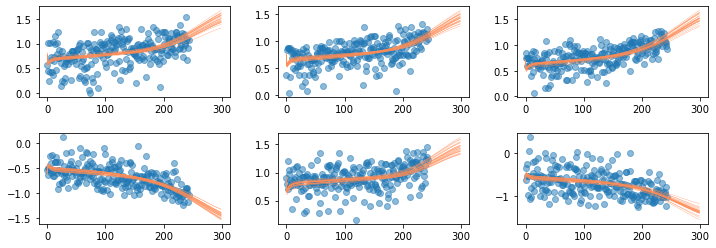

In [33]:
index, K, valid_len = 92, 25, 300
sensor_data = test_data[index]
tmp_Psi = Psi[:valid_len]
gamma_samples = np.random.multivariate_normal(mu_j[index].flatten(), cov_j[index], size=K)

fig = plt.figure(figsize=(12,4))

for i in range(6):
    plt.subplot(2, 3, 1+i)
    plt.plot(sensor_data[:,i], 'o', alpha = 0.5)
    for k in range(K):
        sensor_path = tmp_Psi @ gamma_samples[k].reshape(num_sensors,-1).T
        plt.plot(sensor_path[:,i], color='#FF8D57', linewidth=0.3)
        
plt.subplots_adjust(wspace = 0.25, hspace = 0.4)
plt.show()

In [34]:
def RMSE(true_RUL, pred_RUL):
    d = true_RUL - pred_RUL
    return np.sqrt(np.power(d,2).mean())

def score(true_RUL, pred_RUL):
    d = pred_RUL - true_RUL
    n = len(true_RUL)
    score = np.zeros(n)
    for i in range(n):
        d_i = d[i]
        if d_i >= 0:
            score[i] = np.exp(d_i/10) - 1
        elif d_i < 0:
            score[i] = np.exp(-d_i/13) - 1
    return score.sum()

In [35]:
results1 = np.zeros(50)
results2 = np.zeros(50)
results3 = np.zeros(50)

for l in range(50):
    # 设置特征值
    K = 100 # 超参数
    X_test = np.zeros((num_test, K, Psi.shape[0], num_sensors))
    for i in range(num_test):
        gamma_samples = np.random.multivariate_normal(mu_j[i].flatten(), cov_j[i], size=K)    
        for k in range(K):
            X_test[i,k] = Psi @ gamma_samples[k].reshape(num_sensors,-1).T
            
    pred_RUL = np.zeros(num_test)

    for i in range(num_test):

        p = np.zeros((K, Psi.shape[0]))
        for k in range(K):
            x_i = X_test[i,k]
            p[k] = model2.predict_proba(x_i)[:,1]
        pp = p.mean(axis=0)
        tmp_n = test_lengths[i]
        p_T = (pp - pp[tmp_n])/(1 - pp[tmp_n])
        pred_RUL[i] = np.where(p_T > 0.5)[0][0] - tmp_n
        
    df_RUL = pd.read_csv('RUL_FD001.txt',names=['true_RUL'])
    df_RUL['pred_RUL'] = pred_RUL
    df_RUL['lifetime'] = df_RUL['true_RUL'] + test_lengths
    df_RUL['error'] = np.abs(df_RUL['true_RUL']-df_RUL['pred_RUL'])/df_RUL['lifetime']
    results1[l] = df_RUL['error'].mean()
    results2[l] = RMSE(df_RUL['true_RUL'], df_RUL['pred_RUL'])
    results3[l] = score(df_RUL['true_RUL'], df_RUL['pred_RUL'])

In [36]:
results1.mean(), results1.std()

(0.06790336331844474, 0.000812766936765216)

In [42]:
results2.mean(), results2.std()

(16.785017425713377, 0.11657623470635259)

In [74]:
results3.mean(), results3.std()

(473.2474552813243, 14.363800970702076)

In [37]:
df_RUL.head(20)

,true_RUL,pred_RUL,lifetime,error
0,112,145.0,143,0.230769
1,98,129.0,147,0.210884
2,69,58.0,195,0.056410
3,82,74.0,188,0.042553
4,91,82.0,189,0.047619
5,93,108.0,198,0.075758
6,91,92.0,251,0.003984
7,95,83.0,261,0.045977
8,111,143.0,166,0.192771
9,96,67.0,288,0.100694
